# Run Q3Dfit from this Jupyter Notebook in Astroconda Environment.

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.1. Setting up the directory tree](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)        
* [2. Run Q3Dfit](#chapter2)
* [3. Run plotting script (q3da)](#chapter3)



<font color='red'>We need to decide where the makeqsotemplate functionality goes. </font>

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [11]:
import os.path
import numpy as np

### 1.1. Setting up the directory tree <a class="anchor" id="chapter1_1"></a>

Define the directories in which your data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from Q3Dfit will be saved. 

In [12]:
# book-keeping variables (optional; for this box only)
volume = '/Users/drupke/' # base directory
gal = 'makanisdss' # prefix label for output files

# Input files
infile = volume+'Box Sync/q3d/testing/makani/makanisdss.fits' # path + name of your input cube
stellartemplates = volume+'Box Sync/q3d/testing/makani/makani_stelmod.npy'

# Output directories/files
outdir = volume+'specfits/q3dfit/testing/makanisdss/' # path + name of directory for saving the output files
path_to_npy_file = outdir # path for initproc.npy
logfile = outdir+gal+'_fitlog.txt'
#mapdir = '' # directory for saving the output maps; needed for makemaps.py when it is running

Some general information about your cube:

In [13]:
ncols = 1 # number of columns
nrows = 1 # number of rows
fitrange = [3814, 9201] #in Angstrom

if not os.path.isfile(infile): print('Data cube not found.')

### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

What lines do you want to fit? You can choose from the linelist <font color='red'>provide reference here</font>.

In [15]:
#    lines0 = ['[NeV]3345', '[NeV]3426', 'HeII4686']
#    lines1 = ['[OII]3726', '[OII]3729',
#              '[NeIII]3869', '[NeIII]3967',
#              '[OIII]4959', '[OIII]5007',
#              'Hbeta', 'Hgamma', 'Hdelta', 'Hepsilon']
lines1 = ['[OII]3726', '[OII]3729']
#    lines = lines0 + lines1
lines = lines1

How many components do you want to be fitted to the emission lines?

In [16]:
maxncomp = 2

In [17]:
# Initialize line ties, n_comps, z_inits, and sig_inits.
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
#for i in lines0:
#    linetie[i] = '[NeV]3426'
#    ncomp[i] = np.full((ncols, nrows), maxncomp)
#    zinit_gas[i] = np.full((ncols, nrows,  maxncomp), 0.45666)
#    siginit_gas[i] = np.full(maxncomp, 100)
for i in lines1:
    linetie[i] = '[OII]3729'
    ncomp[i] = np.full((ncols, nrows), maxncomp)
    zinit_gas[i] = np.full((ncols, nrows, maxncomp), 0.45915)
    zinit_gas[i][:, :, 1] = 0.45737
    siginit_gas[i] = np.full(maxncomp, 100)

zinit_stars = np.full((ncols, nrows), 0.459)


linoth = np.full((2, 6), '', dtype=object)
linoth[0, 1] = '[OII]3729'
linoth[0, 2] = 'Hepsilon'
linoth[:, 5] = ['Hbeta', '[OIII]4959']
argspltlin1 = {'nx': 3,
               'ny': 2,
               'label': ['[NeV]3426', '[OII]3726', '[NeIII]3869',
                         'Hgamma', 'HeII4686', '[OIII]5007'],
               'wave': [3426, 3728, 3869, 4340, 4686, 4925],
               'off': [[-100, 100], [-100, 80], [-40, 150],
                       [-100, 100], [-100, 100], [-150, 150]],
               'linoth': linoth}

siglim_gas = np.ndarray(2)
siglim_gas[:] = [5, 1500]


The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [18]:
initproc = { \
            # Required pars
            'fitran': fitrange,
            'fluxunits': 1e-17,  # erg/s/cm^2/arcsec^2
            'infile': infile,
            'label': gal,
            'lines': lines,
            'linetie': linetie,
            'maxncomp': maxncomp,
            'name': 'Makani',
            'ncomp': ncomp,
            'outdir': outdir,
            'zinit_stars': zinit_stars,
            'zinit_gas': zinit_gas,
            'zsys_gas': 0.459,
            # Optional pars
            'datext': 0,
            'varext': 1,
            'dqext': 2,
            'argscheckcomp': {'sigcut': 2},
            'argscontfit': {'siginit_stars': 50,
                            'uselog': 1,
                            'refit': 1},
            'argslinelist': {'vacuum': False,
                             'waveunit': 'Angstrom'},
            'argsinitpar': {'siglim': siglim_gas},
            'startempfile': stellartemplates,
            'argspltlin1': argspltlin1,
            'fcncheckcomp': 'checkcomp',
            'fcncontfit': 'ppxf',
            'maskwidths_def': 2000,
            'emlsigcut': 2,
            'logfile': logfile,
            'siglim_gas': siglim_gas,
            'siginit_gas': siginit_gas,
            'siginit_stars': 50,
            'nocvdf': 1
        }

If you want to run q3dfit in batch mode, run this cell, which saves initproc to an "npy" file. In your python command line, read in that "npy" file with <pre><code> initproc = np.load('path/to/the/npy/file/initproc.npy', allow_pickle=True) </code></pre> and then run q3dfit with <pre><code> q3df(initproc[()],cols=cols,rows=rows) </code></pre>

In [19]:
initproc_npy = 'initproc.npy'
np.save(path_to_npy_file+initproc_npy,initproc)

## 2. Run Q3Dfit <a class="anchor" id="chapter2"></a>

In [20]:
# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

from q3dfit.common.q3df import q3df
from q3dfit.common.q3da import q3da

In [22]:
cols=[1]
rows=[1]

In [ ]:
q3df(initproc,cols=cols,rows=rows,oned=True,quiet=False)

## 3. Run plotting script (q3da) <a class="anchor" id="chapter3"></a>

CUBE: Negative values encountered in variance array.
CUBE: WMAP extension does not exist.
CUBE: wavelength unit does not exist in the header of sci hdu.


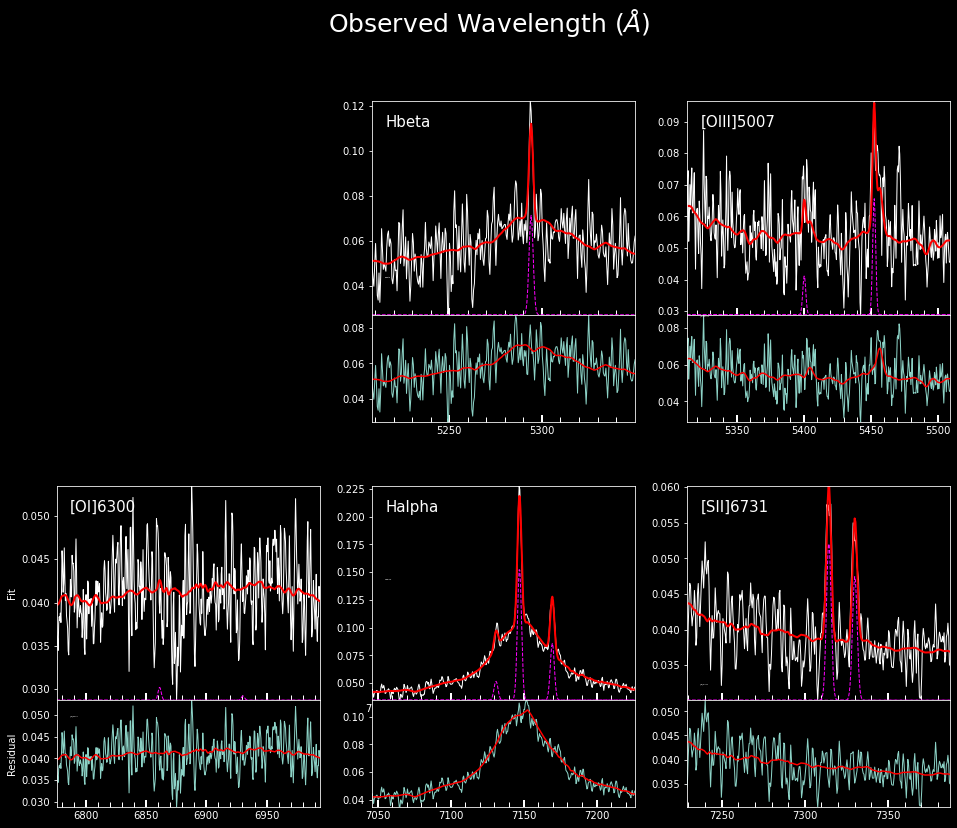

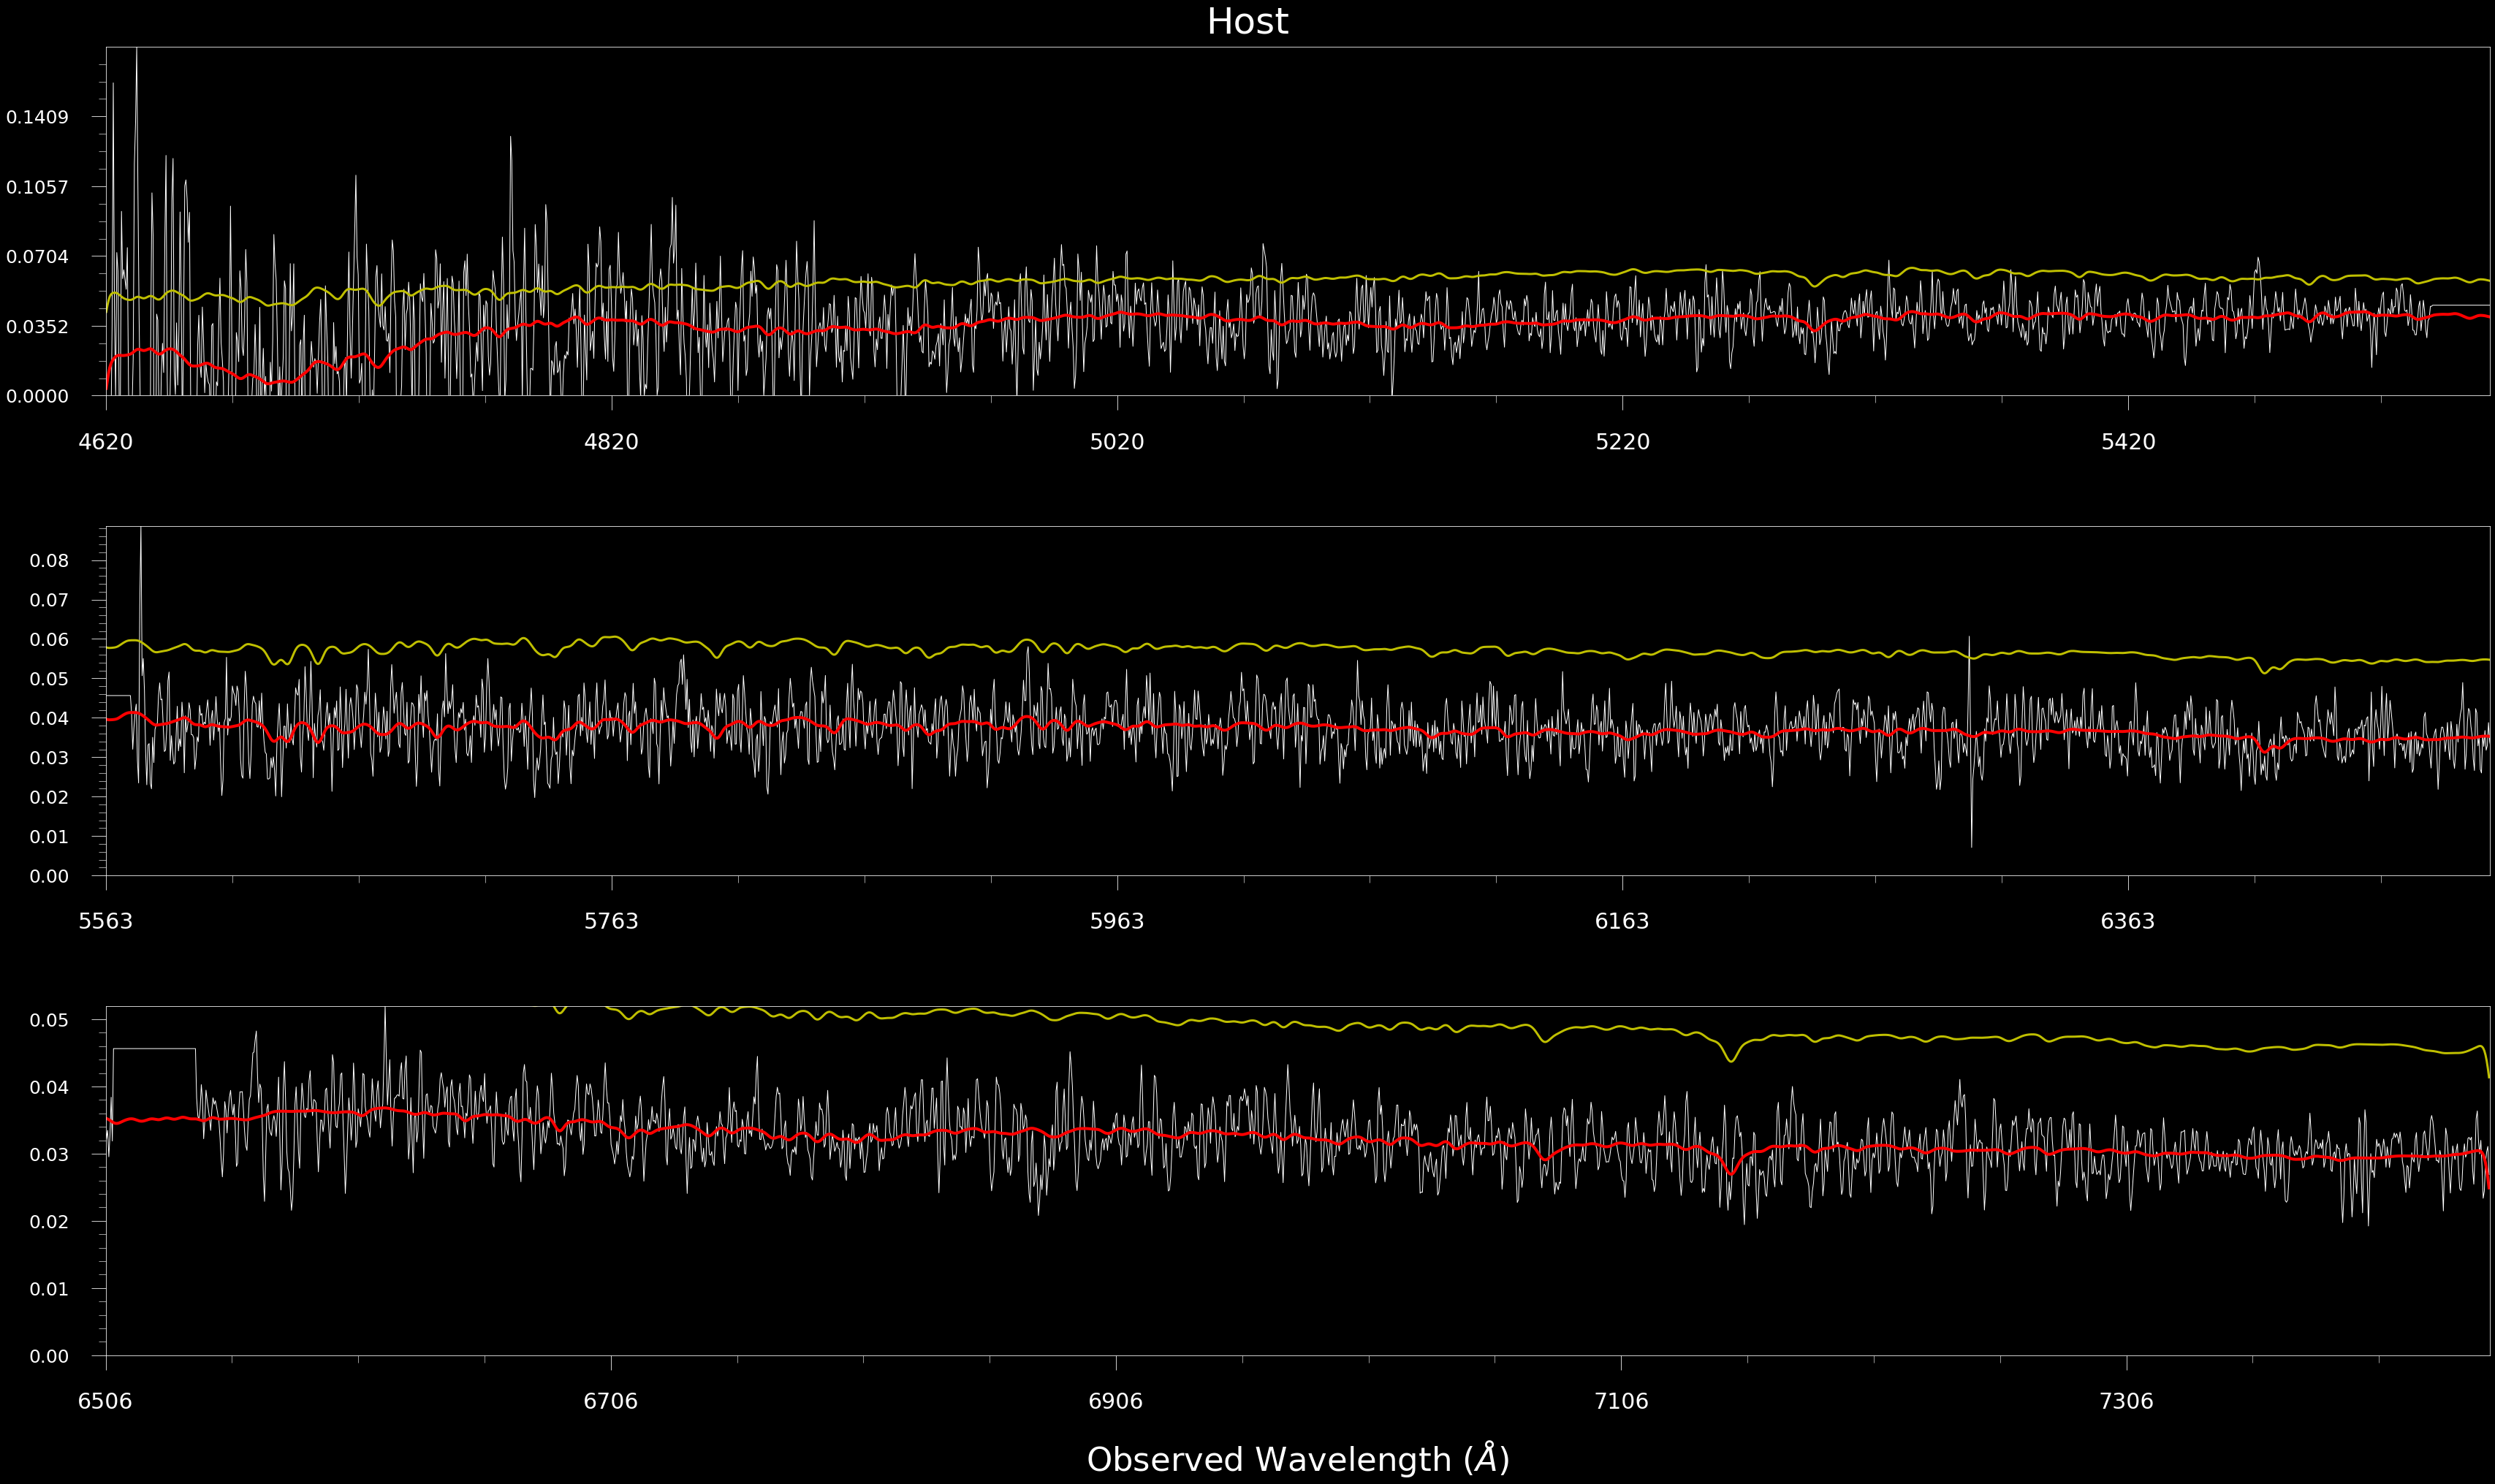

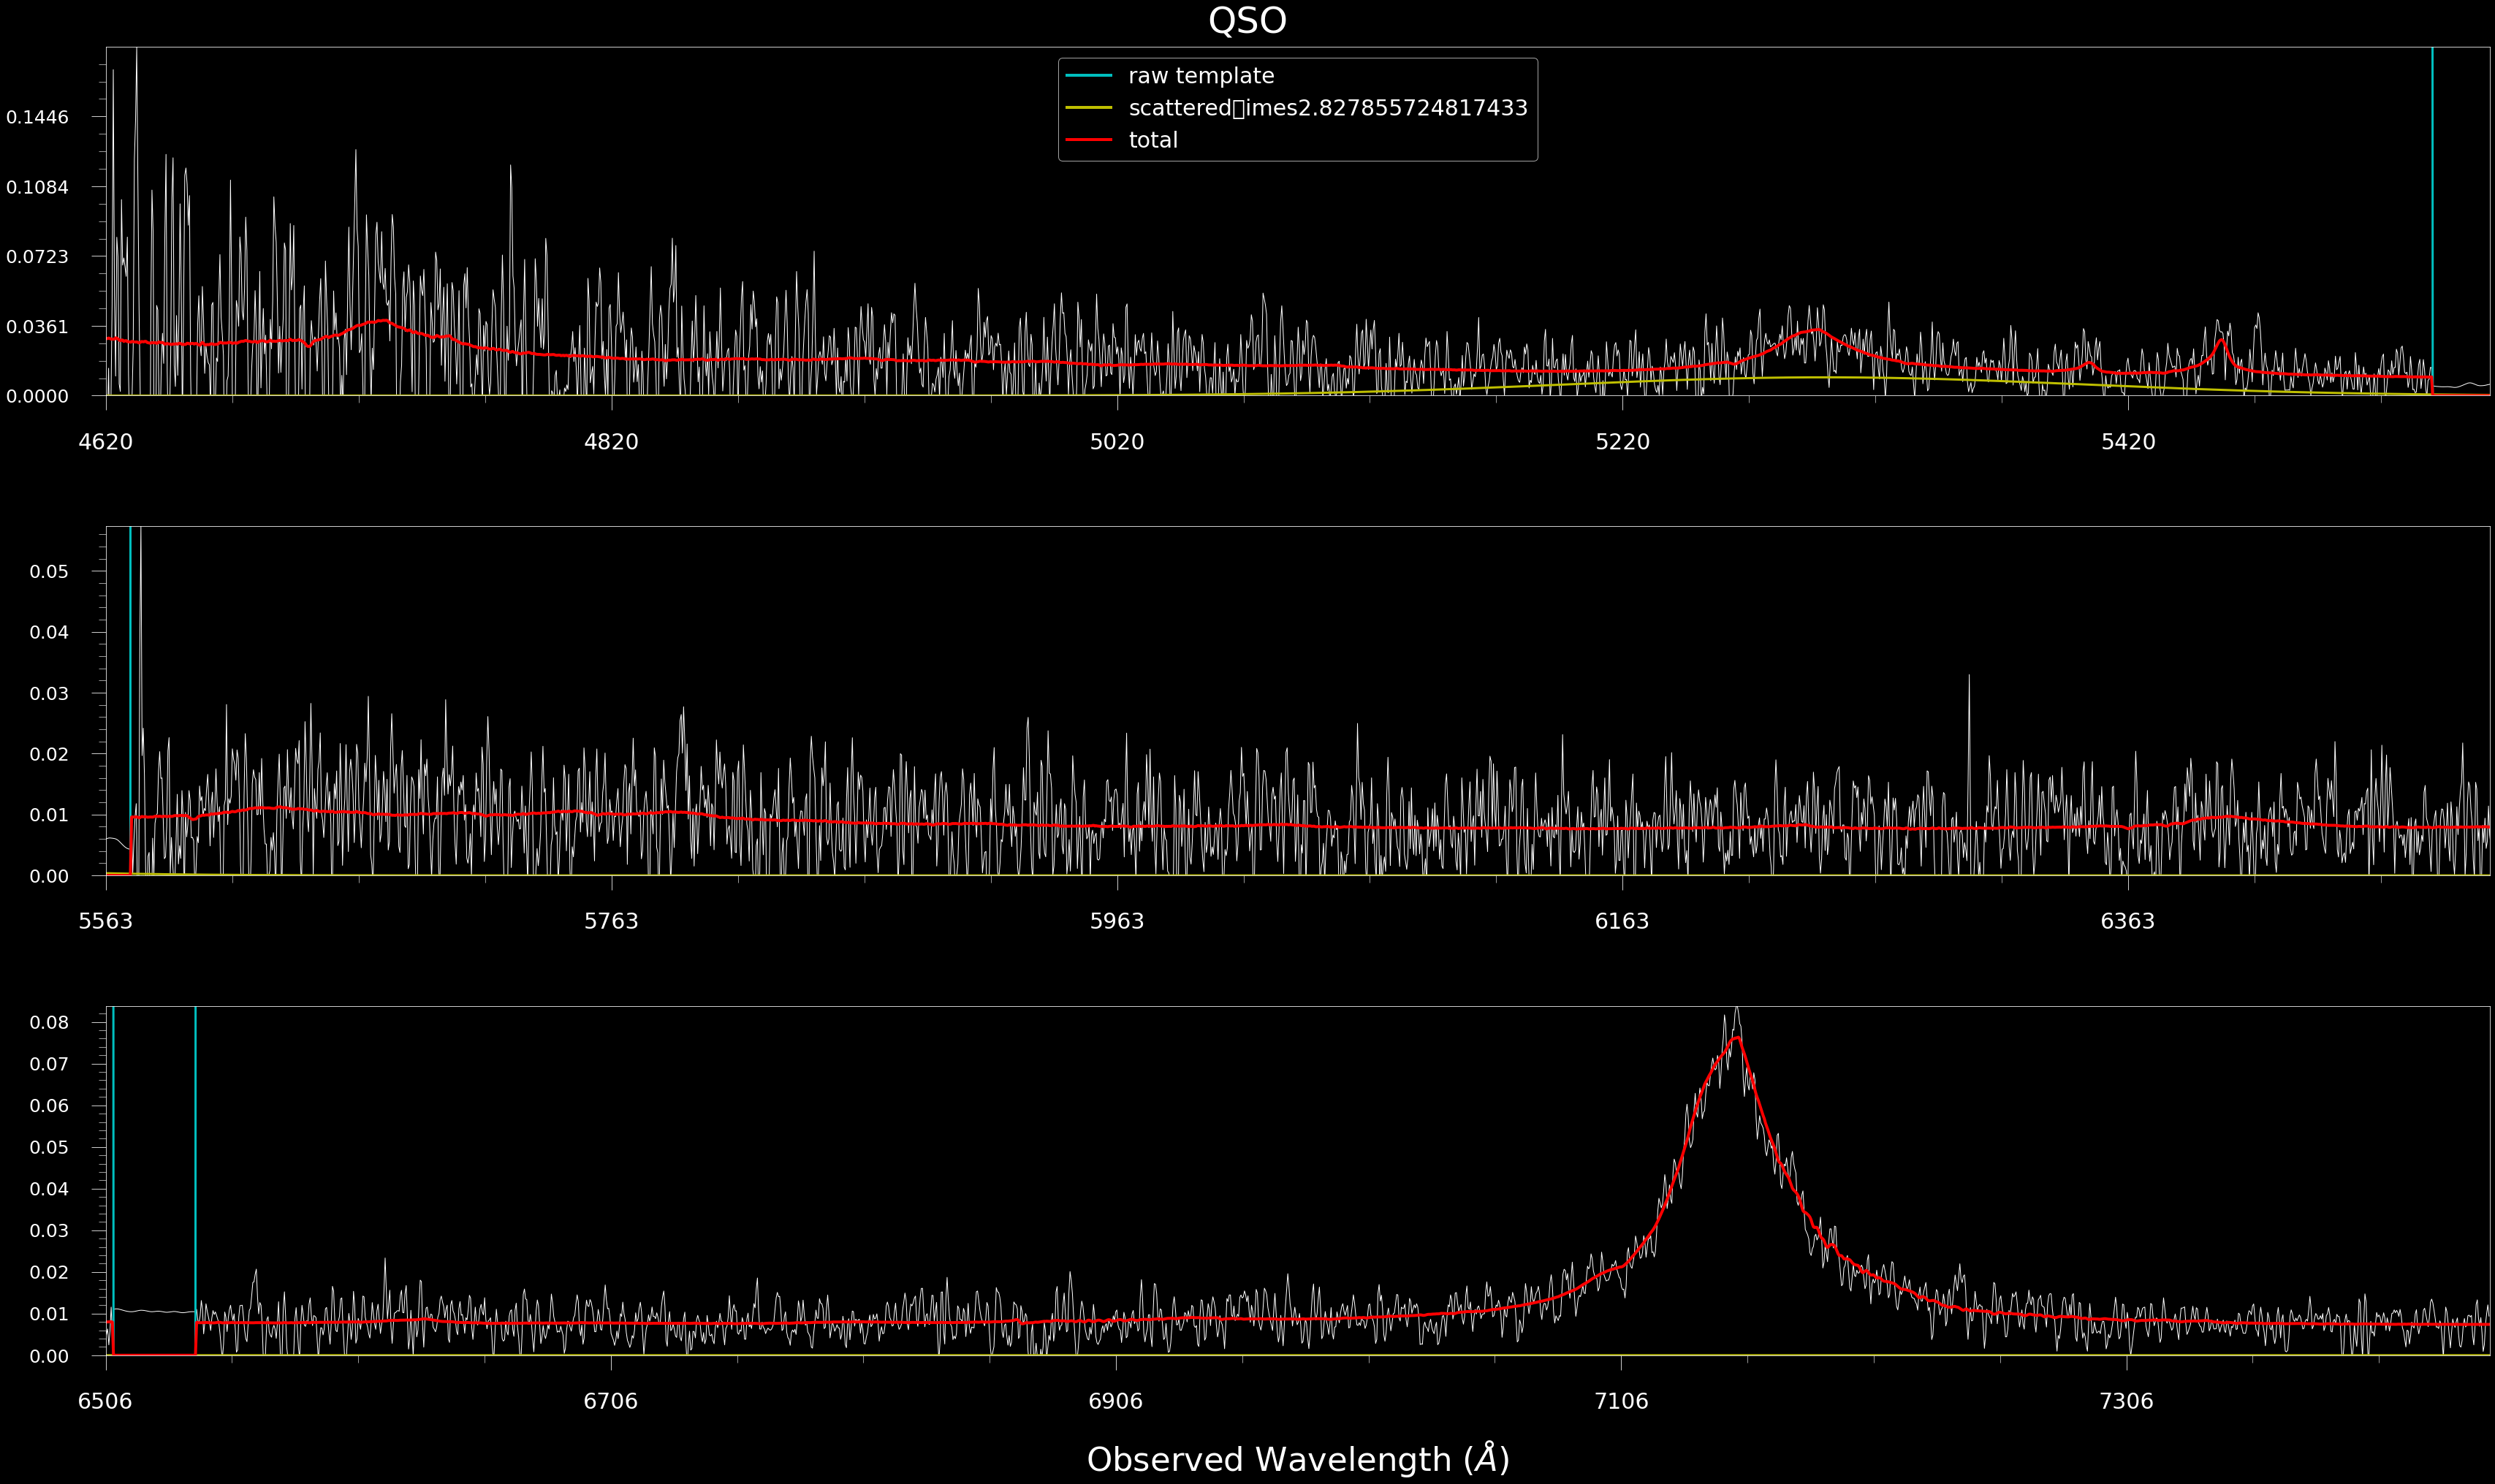

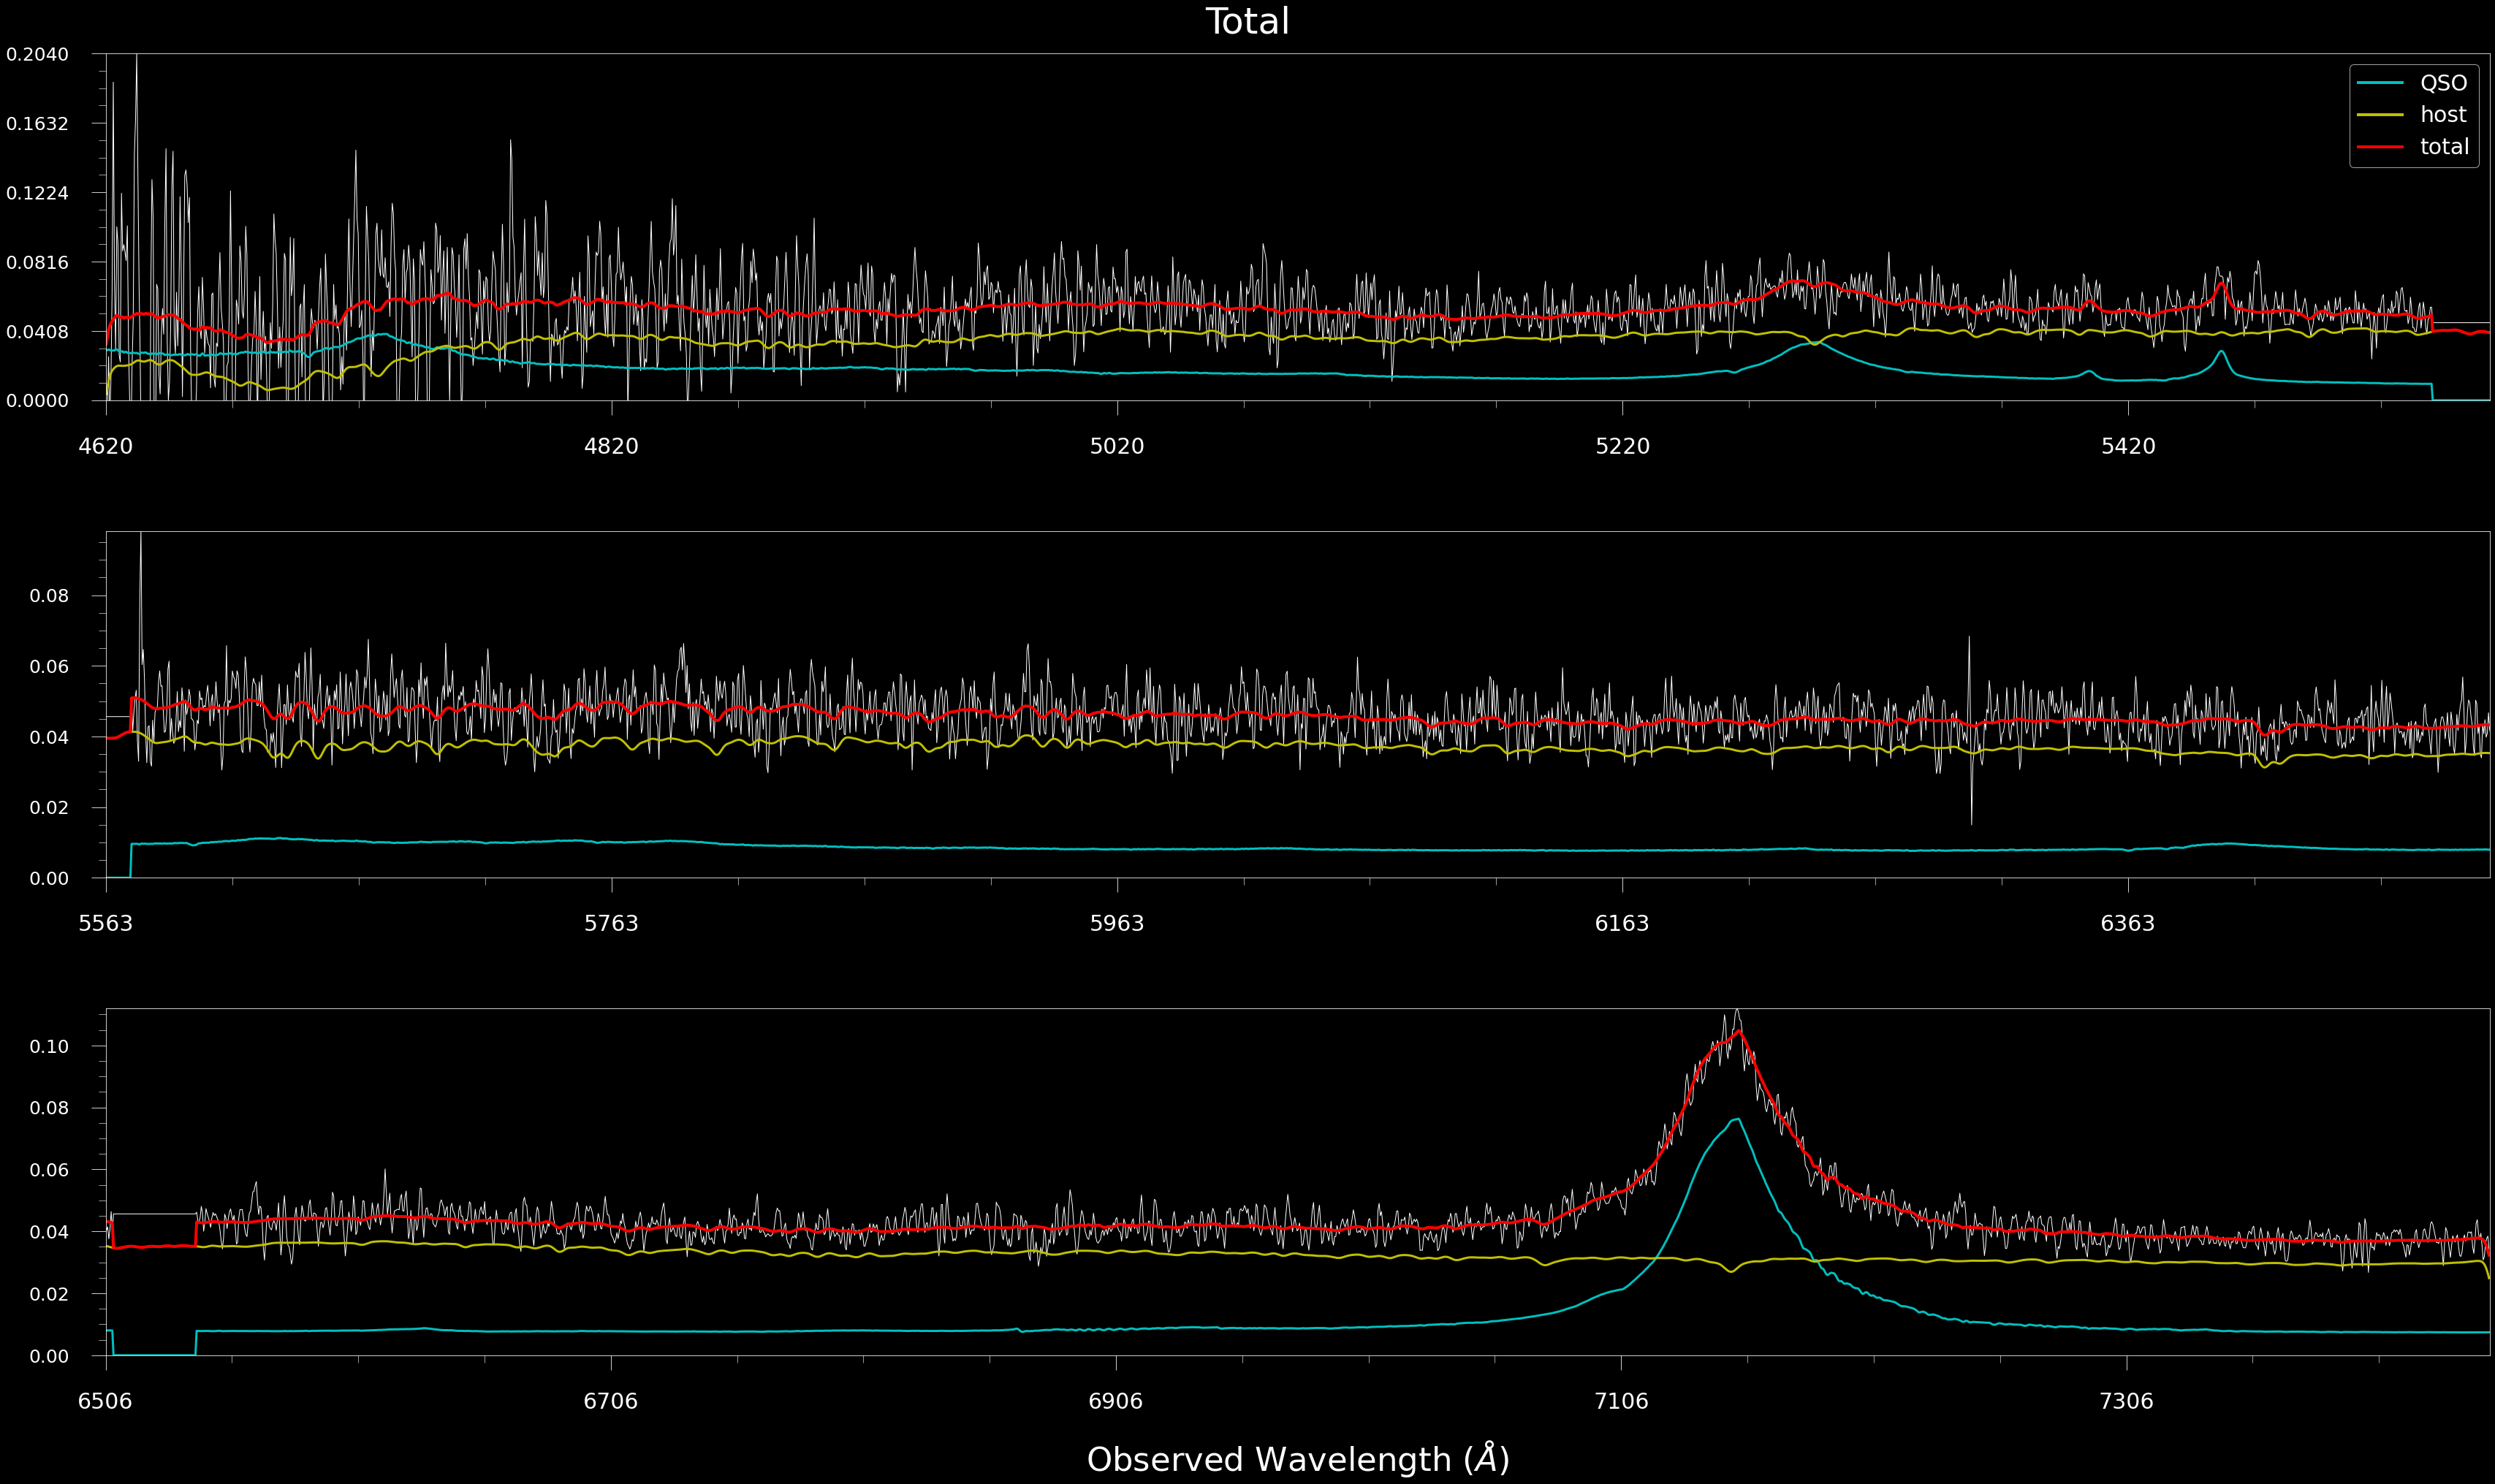

In [23]:
q3da(initproc,cols=cols,rows=rows)